# Stochastic gradient descent

   
## General framework

Consider the task of learning a map $x\mapsto y$ from a training dataset $(x_1, y_1), \dots, (x_n, y_n)$. To do so, we use a parameterized model $f_{w}(x)$ that tries to predict $y$. The parameters $w$ are learned by doing *empirical risk minimization*:
$$
w^*\in\arg\min F(w) = \frac1n\sum_{i=1}^n f_i(w), \enspace \text{with} \enspace f_i(w) = \ell(f_w(x_i), y_i).
$$
Here, $\ell$ is a function that measures a discrepancy in the space of $y$.

## Examples
For instance, when doing regression, i.e. when $y\in\mathbb{R}$ we can use $\ell(y', y) = \frac12(y - y')^2$. When doing binary classification, i.e. when $y\in \pm 1$, we can use the logistic loss
$\ell(y', y) = \log(1+\exp(-y'y))$.

When the model $f_w$ is linear, we are doing linear regression / classification: $f_w(x) = \langle w, x\rangle$.

## Sum structure

We want to minimize $F$, which has a sum structure. We can for instance use gradient descent, starting from $w^0$:

For $t = 0\dots T$:
$$
w^{t+1} = w^t - \rho \nabla F(w^t) = w^t  - \frac{\rho}{n}\sum_{i=1}^n \nabla f_i(w^t).
$$

However, doing one step of gradient descent requires computing all the $\nabla f_i(w^t)$, which is extremely costly when $n$ is large. This is the case in many areas of machine learning, like image processing or natural language processing, where the datasets are huge.

## Stochastic gradient descent (SGD)

An appealing alternative is to use the gradient coming from only one of the $f_i$, where $i$ is chosen at random at each iteration


For $t = 0\dots T$:
$$
w^{t+1} = w^t - \rho \nabla f_i(w^t), \enspace i \sim U(1, n)
$$
This algorithm is called Stochastic Gradient Descent (SGD). It is one of the most important optimization algorithms in datascience, since it is the main algorithm to train neural networks.


**Question 0**: Imagine that we duplicate the training set, so that now we have a dataset of size $2n$ with copies of the original dataset. What happens for gradient descent? What happens for SGD?
## Batch size

In order to leverage the parallelism offered by the computing hardware, it is often more efficient to use a mini-batch rather than a single stochastic gradient: we compute the average of $b$ gradients, where $b$ is the batch size.


For $t = 0\dots T$:
$$
w^{t+1} = w^t - \frac{\rho}{b}\sum_{j=1}^b \nabla f_{i^j}(w^t), \enspace (i^j) \sim P(b, n)
$$
where $P(b, n)$ is the uniform distribution of sets of $b$ distinct integers in $\{1,\dots, n\}$.

Like this, taking $b=1$ corresponds to SGD, and $b= n$ to gradient descent.

We will code it for the Ridge regression problem.

## Ridge regression

For Ridge regression, we have 

$$
F(w) = \frac1{2n}\|Xw - y\|^2 + \frac\lambda2 \|w\|^2
$$

where $X$ is the data matrix and $y$ the target vector.


**Question 1**: For this problem, what is $f_i(w)$?

Below we implement SGD with mini-batch for this problem.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000
p = 20

X = np.random.randn(n, p)
y = np.random.randn(n)
lbda = 0.1

def ridge_loss(w, X, y, lbda):
    n, p = X.shape
    res = np.dot(X, w) - y
    return 0.5 * (np.dot(res, res) / n + lbda * np.dot(w, w))

def stochastic_gradient(w, X, y, lbda, batch_size):
    n, p = X.shape
    idx = np.random.choice(n, batch_size, replace=False)
    X_batch = X[idx, :]
    y_batch = y[idx]
    stoch_grad = np.dot(X_batch.T, np.dot(X_batch, w) - y_batch) / batch_size + lbda * w
    return stoch_grad

In [51]:
def ridge_sgd(w0, X, y, lbda, batch_size, step_size, n_iters=10000):
    w = w0.copy()
    w_list = []
    for i in range(n_iters):
        w -= step_size * stochastic_gradient(w, X, y, lbda, batch_size)
        w_list.append(w.copy())
    return w, w_list

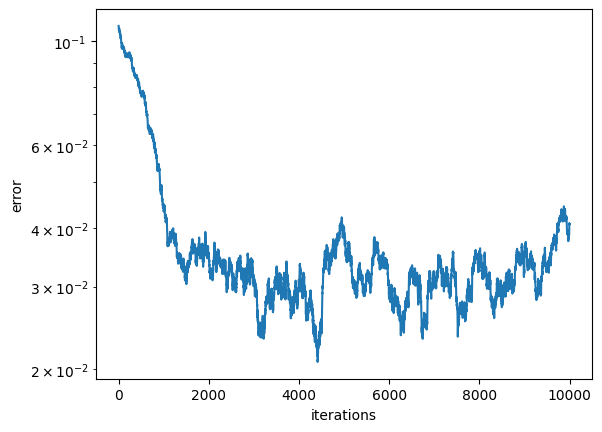

In [52]:
w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, 10, .001)

# ridge_solution should return the solution to the ridge regression problem
def ridge_solution(X, y, lbda):
    n, p = X.shape
    K = np.dot(X.T, X) + lbda * n * np.eye(p)
    return np.linalg.solve(K, np.dot(X.T, y))

w_star = ridge_solution(X, y, lbda)
dists = np.array([np.linalg.norm(w - w_star) for w in w_list])
plt.semilogy(dists)
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

**Question 2**: Investigate the behavior of SGD with different batch size and step size.

In [53]:
batch_sizes = [1, 10, 100]#, 1000]
step_sizes = [0.01, 0.001, 0.0001]
n_iters = 10000
w_star = ridge_solution(X, y, lbda)

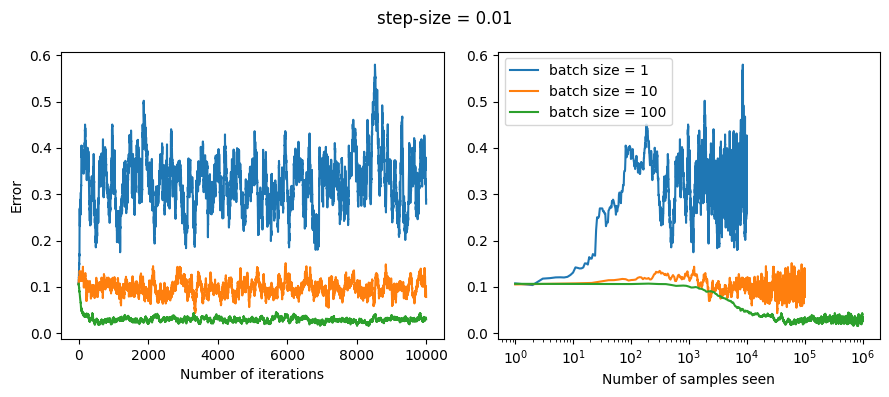

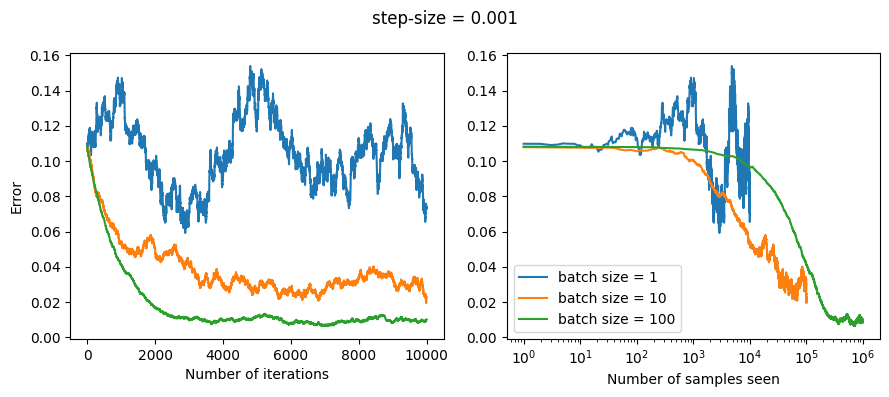

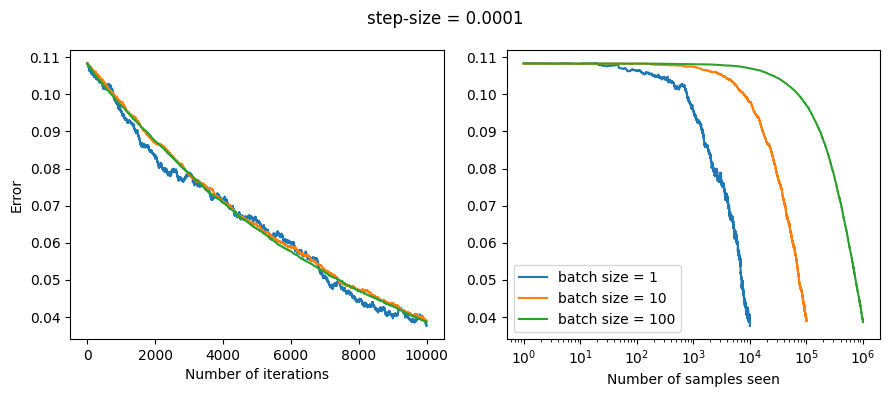

In [54]:

for i, step_size in enumerate(step_sizes):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    for batch_size in batch_sizes:
        w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, batch_size, step_size, n_iters)
        dists = np.array([np.linalg.norm(w - w_star) for w in w_list])

        axes[0].plot(dists, label=f'batch size = {batch_size}')

        n_samples_seen = n_iters * batch_size
        axes[1].semilogx(np.linspace(1, n_samples_seen, n_iters), dists, label=f'batch size = {batch_size}')
    fig.suptitle(f'step-size = {step_size}')
    axes[0].set_ylabel('Error')
    axes[0].set_xlabel('Number of iterations')
    axes[1].set_xlabel('Number of samples seen')
    plt.legend()
    plt.tight_layout()
    plt.show()

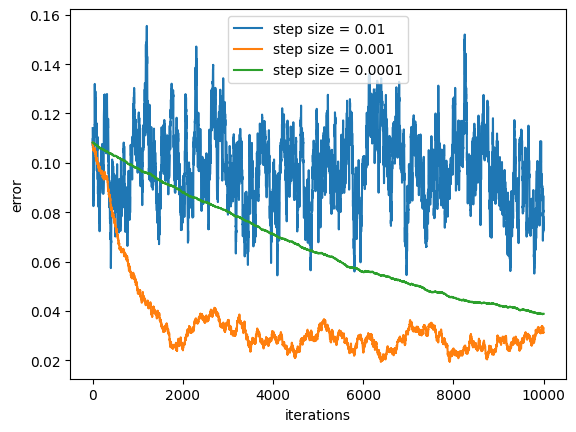

In [55]:
# looking closer at the influence of the step-size
for step_size in [0.01, 0.001, 0.0001]:
    w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, 10, step_size, n_iters)
    dists = np.array([np.linalg.norm(w - w_star) for w in w_list])
    plt.plot(dists, label=f'step size = {step_size}')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

In [56]:
%timeit ridge_sgd(np.zeros(p), X, y, lbda, batch_size=10, step_size=.001, n_iters=1000)
%timeit ridge_sgd(np.zeros(p), X, y, lbda, batch_size=1, step_size=.001, n_iters=10000)

42.7 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
396 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Theoretical analysis

We are now ready to confront our empirical findings with theory. We will suppose that $F$ is $\mu$-strongly convex and $L$- smooth. We recall that it means that for all $x, y$:

$$
F(y) \leq F(x) + \langle \nabla F(x), y - x\rangle + \frac L2\|x - y\|^2
$$
$$
F(y) \geq F(x) + \langle \nabla F(x), y - x\rangle + \frac \mu 2\|x - y\|^2
$$

**Question 3**

Show that strong-convexity implies that for all $w$, and for $w^*$ such that $\nabla F(w^*)= 0$, we have
$$
\langle \nabla F(w), w - w^*\rangle \geq \frac\mu2\|w-w^*\|^2
$$



We will also make an assumption on the variance of the stochastic gradients:

$$
\frac1n\sum_{i=1}^n \|\nabla f_i(w)\|^2 \leq B^2
$$


For simplicity, we assume that the batch size is $1$.

**Question 4** Show that 
$$
\mathbb{E}_{i}[\|w^{t+1} - w^*\|^2]\leq (1 - \rho \mu)\|w^t - w^*\|^2 +\rho^2 B^2
$$

where expectation is taken with respect to the random index $i$ at iteration $t$.

**Question 5** Find a bound on 
$$
\mathbb{E}[\|w^{t+1} - w^*\|^2]
$$
where expectation is now taken with respect to the whole past. Do you recover what you observed ?


**Question 6** What can we do to make this algorithm truly converge?